In [ ]:
from local.imports import *
from local.test import *
from local.core import *
from local.layers import *
from local.data.all import *
from local.optimizer import *
from local.learner import *
from local.metrics import *
from local.callback.all import *
from local.vision.all import *

# Tutorial: Training a model on Imagenette

> Regular training with square images and rectangular training

## Square training

### Loading the data with `DataSource`

To load the data with the mdeium-level API `DataSource`, we need to gather all the images and define some way to split them betweem training and validation.

In [ ]:
source = untar_data(URLs.IMAGENETTE_160)
items = get_image_files(source)
split_idx = GrandparentSplitter(valid_name='val')(items)

Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `paent_label` function to convert a filename to its class, followed by `Categorize`.

The dataset transforms contain data augmentation using PIL and a resize to 128.

In [ ]:
tfms = [PILImage.create, [parent_label, Categorize()]]
ds_img_tfms = [PILFlip(0.5), RandomResizedCrop(128, min_scale=0.35)]

We can then pass all of this informtaiton to `DataSource`.

In [ ]:
dsrc = DataSource(items, tfms, filts=split_idx, ds_tfms=ds_img_tfms)

To convert our `DataSource` to a `DataBunch`, we need to indicate the transforms we want to use at the batch level, here putting on the GPU aith `Cuda`, converting the tensors of bytes to float then normalizing using the traditional imagenet statistics.

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
imagenet_stats = broadcast_vec(1, 4, *imagenet_stats)

In [ ]:
tfms = [Cuda(), ByteToFloatTensor(), Normalize(*imagenet_stats)]
dbch = dsrc.databunch(tfms, bs=64, num_workers=8)

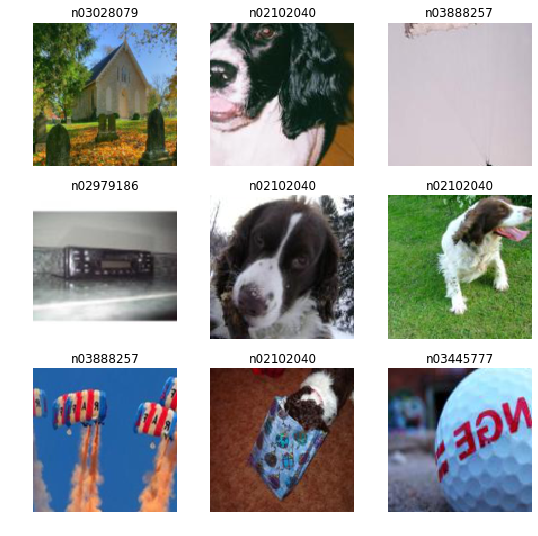

In [ ]:
dbch.show_batch(max_samples=9)

### Loading the data with `DataBlock`

An easier way is to use the `DataBlock` higher-level API. We just need to specify the types, how to get the items, how to split them and how to label to build an Imagenette datablock.

In [ ]:
imagenette = DataBlock(ts=(PILImage, Category), 
                       get_items=get_image_files, 
                       splitter=GrandparentSplitter(valid_name='val'),
                       labeller=parent_label)

We can then directly call the `databunch` method when specifying a source (where the items are) and the non-default dataset and dataloader transforms. To check which transforms are included by default (inferred from the types passed), we can check (and poentially modify) the attributes `default_type_tfms`, `default_ds_tfms` and `default_dl_tfms` of the `imagenette` object.

In [ ]:
imagenette.default_type_tfms,imagenette.default_ds_tfms,imagenette.default_dl_tfms

({local.vision.core.PILImage: (#1) [<bound method PILBase.create of <class 'local.vision.core.PILImage'>>],
  local.data.core.Category: (#1) [<class 'local.data.core.Categorize'>]},
 (#0) [],
 (#2) [ByteToFloatTensor: True {'TensorMask': 'encodes', 'TensorImage': 'encodes'} {'TensorMask': 'decodes', 'TensorImage': 'decodes'},Cuda: False {'object': 'encodes'} {'object': 'decodes'}])

Here we need to add the data augmentation and resize, as well as the normalization.

In [ ]:
dbch = imagenette.databunch(source, bs=64, num_workers=8, ds_tfms=ds_img_tfms, dl_tfms=Normalize(*imagenet_stats))

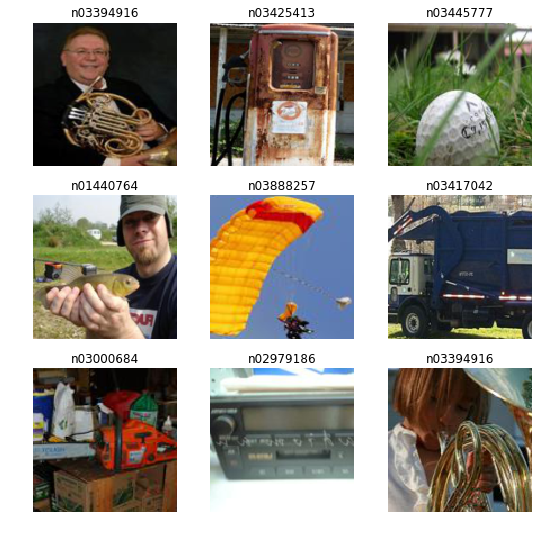

In [ ]:
dbch.show_batch(max_samples=9)

### Training

The following function will give us a `Learner` to train a model on imagenette.

In [ ]:
def cnn_learner(arch, data, loss_func, opt_func, c_in=None, c_out=None,
                lr=1e-2, progress=True, mixup=0, xtra_cb=None, **kwargs):
    cbfs = [MixedPrecision]
    arch_args = {}
    if not c_in : c_in  = data.c_in
    if not c_out: c_out = data.c_out
    if c_in:  arch_args['c_in' ]=c_in
    if c_out: arch_args['c_out']=c_out
    return Learner(arch(**arch_args), data, loss_func, opt_func=opt_func, lr=lr, cb_funcs=cbfs, **kwargs)

In [ ]:
opt_func = partial(Adam, wd=0.01, eps=1e-3)

To use label smoothing, we define a custom loss function.

In [ ]:
class LabelSmoothingCrossEntropy(Module):
    def __init__(self, eps:float=0.1, reduction='mean'): self.eps,self.reduction = eps,reduction  
    
    def forward(self, output, target):
        c = output.size()[-1]  
        log_preds = F.log_softmax(output, dim=-1)
        if self.reduction=='sum': loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':  loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * F.nll_loss(log_preds, target, reduction=self.reduction)

In [ ]:
learn = cnn_learner(xresnet18, dbch, LabelSmoothingCrossEntropy(), opt_func=opt_func, c_in=3, c_out=10, lr=1e-2, metrics=accuracy)

Then we can train our model.

In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,1.780073,1.657118,0.530000,00:20
1,1.496069,1.487080,0.626000,00:20
2,1.362790,1.449322,0.618000,00:20
3,1.256833,1.444427,0.572000,00:19
4,1.150916,1.223983,0.720000,00:20
5,1.080450,1.018281,0.788000,00:21
6,1.026293,1.118729,0.750000,00:22
7,0.966814,1.027267,0.794000,00:22
8,0.924269,0.862362,0.864000,00:21
9,0.886563,0.886196,0.858000,00:23


## Rect training

For a rectangular training, we change the dataset transforms to use the flip only. We will resize the images when it's time to batch them only.

In [ ]:
ds_img_tfms = [PILFlip(0.5)]
tfms = [PILImage.create, [parent_label, Categorize()]]
dsrc = DataSource(items, tfms, filts=split_idx, ds_tfms=ds_img_tfms)

In [ ]:
tfms = [Cuda(), ByteToFloatTensor(), Normalize(*imagenet_stats)]
bs = 64

We use a sampler that will group the images by batches of the close size and aspect ratio (with a bit of shuffle for the training set) and a collation function that will resize them to the mdeian aspect ratio and median number of pixel (bound by `max_px`). `rand_min_scale` is used to do a `RandomResizedCrop` to that size on the training set.

In [ ]:
samp = SortARSampler(dsrc.train, shuffle=True, bs=bs)
collate_fn = ResizeCollate(max_px=128*128, rand_min_scale=0.35, rand_ratio_pct=0.33, round_mult=32)
train_dl = TfmdDL(dsrc.train, tfms, num_workers=8, batch_sampler=samp, collate_fn=collate_fn)

In [ ]:
samp = SortARSampler(dsrc.valid, shuffle=False, bs=bs)
collate_fn = ResizeCollate(max_px=128*128, round_mult=32)
valid_dl = TfmdDL(dsrc.valid, tfms, num_workers=8, batch_sampler=samp, collate_fn=collate_fn)

Then we create a `DataBunch` with those two dataloaders.

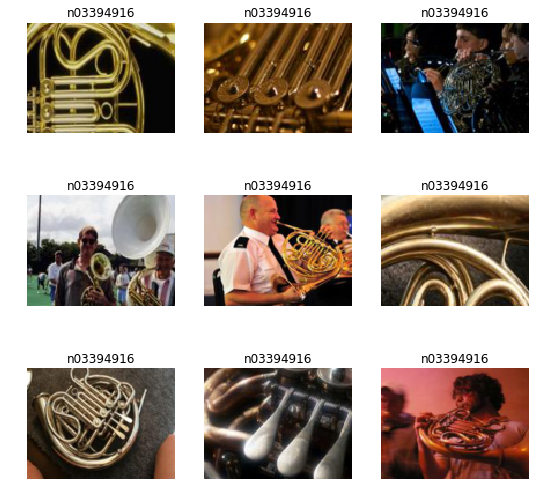

In [ ]:
dbch = DataBunch(train_dl, valid_dl)
dbch.show_batch(max_samples=9)

### Training

The training then works exactly as before.

In [ ]:
learn = cnn_learner(xresnet18, dbch, LabelSmoothingCrossEntropy(), opt_func=opt_func, c_in=3, c_out=10, lr=1e-2, metrics=accuracy)

In [ ]:
learn.fit_one_cycle(20)

epoch,train_loss,valid_loss,accuracy,time
0,2.307950,2.140837,0.246000,00:24
1,2.293546,2.080190,0.266000,00:23
